In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pandas.api.types import is_numeric_dtype
from pprint import pprint, pformat
import zipfile
from pathlib import Path


import joblib

from my_lib import *
from my_config import *

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

from sklearn.linear_model import LinearRegression # для построения моделей линейной регрессии
from sklearn.preprocessing import PolynomialFeatures # для преобразования исходных признаков в полиномиальные, для построения моделей полиномиальной регрессии
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

In [13]:
def prepare_dataset(dataset_full_name, params_full_name, scaler, train_size=0.7):
    """Загрузить датасет, разделить на тренировочную и тестовую выборки и прогнать через указанный нормализатор"""
    dataset_df = joblib.load(dataset_full_name)
    params = joblib.load(params_full_name)
    np.random.seed(42)
    X_train, X_test, y_train, y_test = train_test_split(dataset_df[params["columns_X"]], 
                                                        dataset_df[params["target_column"]], 
                                                        train_size=train_size, 
                                                        stratify=dataset_df[params["target_column"]])
    # Нормировка признаков
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)        
    return dataset_df, params, X_train, X_test, y_train, y_test

def fit_model_svc(X_train, y_train, X_test, y_test, best_params):
    """Построить модель SVC с заданными параметрами параметрами.
    Прогнать её на тренировочной и тестовой выборках и вычислить метрики"""
    # построить модель
    model = SVC(**best_params, probability=True)
    # Обучение модели
    model.fit(X_train, y_train)
    # Предсказание вероятностей на обучающей и тестовой выборке
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Расчет AUC-ROC
    roc_auc_train = roc_auc_score(y_train, y_train_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_proba)

    # Поиск порога, максимизирующего F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_proba >= t) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    # Пересчет метрик с учетом оптимального порога
    y_train_pred_optimal = (y_train_proba >= optimal_threshold).astype(int)
    y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

    train_precision = precision_score(y_train, y_train_pred_optimal)
    train_recall = recall_score(y_train, y_train_pred_optimal)

    test_precision = precision_score(y_test, y_test_pred_optimal)
    test_recall = recall_score(y_test, y_test_pred_optimal)
    
    train_accuracy = accuracy_score(y_train, y_train_pred_optimal)
    test_accuracy = accuracy_score(y_train, y_train_pred_optimal)

    result = {'model': model,
              'model_params': best_params,
              'optimal_threshold': optimal_threshold,
              'y_train_proba': y_train_proba,
              'y_test_proba': y_test_proba,
              'y_train_pred_optimal': y_train_pred_optimal,
              'y_test_pred_optimal': y_test_pred_optimal,
              'roc_auc_train': roc_auc_train,
              'roc_auc_test': roc_auc_test,
              'train_precision': train_precision,
              'train_recall': train_recall,
              'train_accuracy': train_accuracy,
              'test_precision': test_precision,
              'test_recall': test_recall,
              'test_accuracy': test_accuracy,
              'metrics': {
                    'params': [
                        'Training_Precision', 'Test_Precision',
                        'Training_Recall', 'Test_Recall',
                        'ROC_AUC_Train', 'ROC_AUC_Test',
                        'Accuarcy_Train', 'Accuarcy_Test'
                    ],
                    'values': [
                        train_precision, test_precision,
                        train_recall, test_recall,
                        roc_auc_train, roc_auc_test,
                        train_accuracy, test_accuracy
                    ]
                }              
    }
    return result

def svm_model(X_train, X_test, y_train, y_test, dataset_mark):
    """Подобрать оптимальные параметры для построения SVC-модели,
    построить и потренировать модель. Результаты сохранить в файл"""
    # Определяем сетку параметров для C, которые мы хотим проверить
    param_grid = {'C': [0.01, 0.1, 1, 5, 10],
                'kernel':['linear', 'poly', 'rbf', 'sigmoid']
                }
    svm_model = SVC()
    # Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
    grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации
    # Обучаем модель на данных с использованием кросс-валидации
    grid_search.fit(X_train, y_train)

    result = fit_model_svc(X_train, y_train, X_test, y_test, grid_search.best_params_)    
    result['dataset_mark'] = dataset_mark

    joblib.dump(result, Path(result_foler, model_template_filename % f"df_{dataset_mark}_svm_kernel_{grid_search.best_params_["kernel"],}"), compress=3)
    joblib.dump({'fit_result': result, 
                 'y_train': y_train, 
                 'y_test': y_test
                },
                Path(result_foler, result_model_template_filename % f"{dataset_mark}"), compress=3)
    
    return result

def show_svc_result(result):
    """Визуализировать метрики модели"""
    print('Подобранные параметры модели:', result['fit_result']["model_params"])

    print(f"ROC-AUC Train: {result['fit_result']["roc_auc_train"]:.2f}")
    print(f"ROC-AUC Test: {result['fit_result']["roc_auc_test"]:.2f}")

    # Построение ROC-кривой
    fpr_train, tpr_train, _ = roc_curve(result["y_train"], result['fit_result']["y_train_proba"])
    fpr_test, tpr_test, _ = roc_curve(result["y_test"], result['fit_result']["y_test_proba"])
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC Curve Train')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC Curve Test')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({type(result['fit_result']["model"]).__name__})')
    plt.legend()
    plt.show()

    print(f"Optimal Threshold: {result['fit_result']["optimal_threshold"]:.2f}")
    print(f"Optimal Training Precision: {result['fit_result']["train_precision"]:.2f}")
    print(f"Optimal Training Recall: {result['fit_result']["train_recall"]:.2f}")
    print(f"Optimal Test Precision: {result['fit_result']["test_precision"]:.2f}")
    print(f"Optimal Test Recall: {result['fit_result']["test_recall"]:.2f}")
    
    # Вычисление матрицы ошибок
    cm = confusion_matrix(result['y_test'], result['fit_result']['y_test_pred_optimal'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    # Визуализация матрицы
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt=".2f", 
        cmap="Blues",
        #xticklabels=data.target_names,
        #yticklabels=data.target_names
    )
    plt.title(f"Confusion Matrix {result['fit_result']["dataset_mark"]}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()    

In [5]:
from multiprocessing import Process

def process_dataset(dataset_mark, dataset_filename, params_filename):
    """Обработать указанный датасет"""
    dataset_full_name = Path(result_foler, dataset_filename)
    params_full_name = Path(result_foler, params_filename)
    _, _, X_train, X_test, y_train, y_test = prepare_dataset(dataset_full_name, params_full_name, StandardScaler())
    svm_model(X_train, X_test, y_train, y_test, dataset_mark)

# Обработать разные варианты датасета

In [6]:
# Обработать датасеты в многопроцессном режиме
dataset_mark_orig = "original"
dataset_mark_minmax = "minmax"
dataset_mark_median = "median"

if __name__ == '__main__':
    p_original = Process(target=process_dataset, args=(dataset_mark_orig, dataset_filename_ready_for_train_original, params_filename_ready_for_train_original))
    p_minmax = Process(target=process_dataset, args=(dataset_mark_minmax, dataset_filename_ready_for_train_wo_outliers_minmax, params_filename_ready_for_train_wo_outliers_minmax))
    p_median = Process(target=process_dataset, args=(dataset_mark_median, dataset_filename_ready_for_train_wo_outliers_median, params_filename_ready_for_train_wo_outliers_median))

    p_original.start()
    p_minmax.start()
    p_median.start()
    p_original.join()
    p_minmax.join()
    p_median.join()

## Результаты обработки оригинального датасета

Подобранные параметры модели: {'C': 5, 'kernel': 'rbf'}
ROC-AUC Train: 0.89
ROC-AUC Test: 0.83


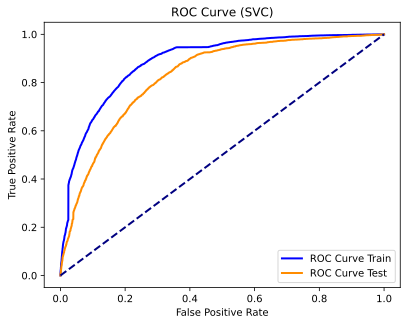

Optimal Threshold: 0.24
Optimal Training Precision: 0.64
Optimal Training Recall: 0.91
Optimal Test Precision: 0.58
Optimal Test Recall: 0.88


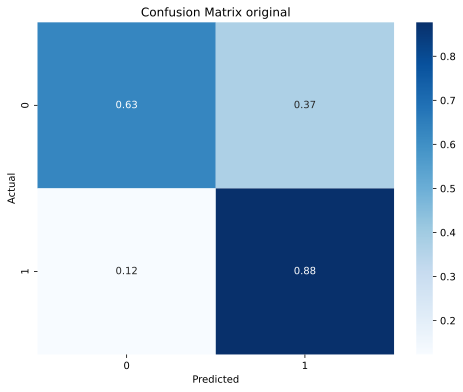

,params,values,metrics
0,Training_Precision,0.63950,original
1,Test_Precision,0.57880,original
2,Training_Recall,0.91279,original
3,Test_Recall,0.87709,original
4,ROC_AUC_Train,0.88711,original
5,ROC_AUC_Test,0.82624,original
6,Accuarcy_Train,0.77899,original
7,Accuarcy_Test,0.77899,original


In [14]:
result_original = joblib.load(Path(result_foler, result_model_template_filename % f"{dataset_mark_orig}"))
show_svc_result(result_original)
result_original['fit_result']['metrics']['metrics'] = [dataset_mark_orig for i in range(8)]
df_stat = pd.concat([pd.DataFrame(result_original['fit_result']['metrics'])])
df_stat

## Результаты обработки датасета с заменой выбросов на крайние значения

Подобранные параметры модели: {'C': 1, 'kernel': 'rbf'}
ROC-AUC Train: 0.87
ROC-AUC Test: 0.83


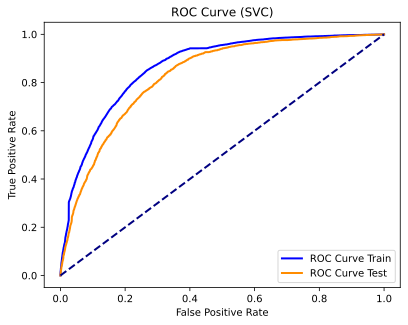

Optimal Threshold: 0.24
Optimal Training Precision: 0.62
Optimal Training Recall: 0.89
Optimal Test Precision: 0.58
Optimal Test Recall: 0.87


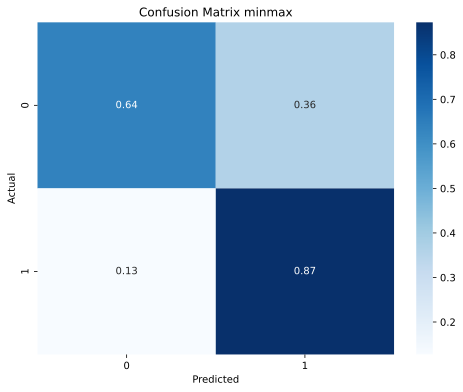

,params,values,metrics
0,Training_Precision,0.61635,minmax
1,Test_Precision,0.58348,minmax
2,Training_Recall,0.89304,minmax
3,Test_Recall,0.87291,minmax
4,ROC_AUC_Train,0.86545,minmax
5,ROC_AUC_Test,0.82692,minmax
6,Accuarcy_Train,0.75656,minmax
7,Accuarcy_Test,0.75656,minmax


In [15]:
result_minmax = joblib.load(Path(result_foler, result_model_template_filename % f"{dataset_mark_minmax}"))
show_svc_result(result_minmax)
result_minmax['fit_result']['metrics']['metrics'] = [dataset_mark_minmax for i in range(8)]
df_stat = pd.concat([pd.DataFrame(result_minmax['fit_result']['metrics'])])
df_stat

## Результаты обработки датасета с заменой выбросов на медиану

Подобранные параметры модели: {'C': 5, 'kernel': 'rbf'}
ROC-AUC Train: 0.90
ROC-AUC Test: 0.81


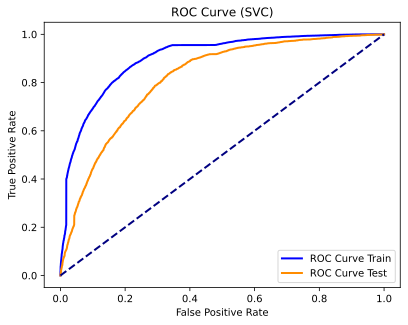

Optimal Threshold: 0.28
Optimal Training Precision: 0.67
Optimal Training Recall: 0.90
Optimal Test Precision: 0.59
Optimal Test Recall: 0.84


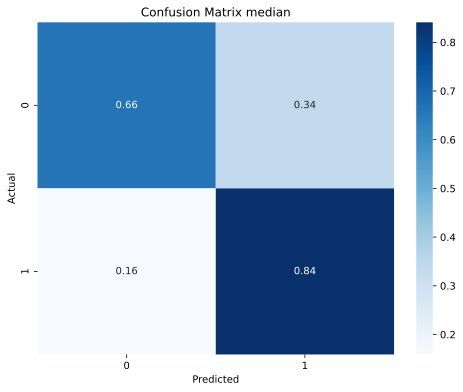

,params,values,metrics
0,Training_Precision,0.67031,median
1,Test_Precision,0.58959,median
2,Training_Recall,0.89992,median
3,Test_Recall,0.84101,median
4,ROC_AUC_Train,0.90162,median
5,ROC_AUC_Test,0.81483,median
6,Accuarcy_Train,0.80068,median
7,Accuarcy_Test,0.80068,median


In [16]:
result_median = joblib.load(Path(result_foler, result_model_template_filename % f"{dataset_mark_median}"))
show_svc_result(result_median)
result_median['fit_result']['metrics']['metrics'] = [dataset_mark_median for i in range(8)]
df_stat = pd.concat([pd.DataFrame(result_median['fit_result']['metrics'])])
df_stat

## Сделать результаты более читабельными

In [17]:
df_stat = pd.concat([pd.DataFrame(result_original['fit_result']['metrics']),
                     pd.DataFrame(result_minmax['fit_result']['metrics']),
                     pd.DataFrame(result_median['fit_result']['metrics'])
                     ])

df_stat2 = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall', 
                                                            'ROC_AUC_Train', 'ROC_AUC_Test']]
df_stat2

params,metrics,Test_Precision,Training_Precision,Test_Recall,Training_Recall,ROC_AUC_Train,ROC_AUC_Test
0,median,0.58959,0.67031,0.84101,0.89992,0.90162,0.81483
1,minmax,0.58348,0.61635,0.87291,0.89304,0.86545,0.82692
2,original,0.57880,0.63950,0.87709,0.91279,0.88711,0.82624


In [18]:
df_stat2.T

,0,1,2
params,,,
metrics,median,minmax,original
Test_Precision,0.58959,0.58348,0.57880
Training_Precision,0.67031,0.61635,0.63950
Test_Recall,0.84101,0.87291,0.87709
Training_Recall,0.89992,0.89304,0.91279
ROC_AUC_Train,0.90162,0.86545,0.88711
ROC_AUC_Test,0.81483,0.82692,0.82624


In [19]:
joblib.dump(df_stat.T, Path(result_foler, result_file_name), compress=3)


['/home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.05. Классификация SVM/result/04_result.pickle']

# Выводы

Результаты слабо зависят от предварительной подготовки (обработки выбросов) датасете - результаты сопоставимы, разниза по метрикам в пределах 1-2%.
Можно только сказать, что замена выбросов на ближайшее значение в +-1.5IQR дает чуть худший результат чем оригинальный датасет или замена на медианное значение.

Оптимальные гиперпараметры моделей:
  * 'C': 5
  * 'kernel': 'rbf'

Для оригинального датасета модель верно предсказывает 88% курящих и 68% некурящих. При этом ложноположительных ошибок - 37%, ложноотрицательных - 12%